In [1]:
#conda install xgboost

In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, log_loss
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve

Since the pre-designated test dataset does not have include values for the target feature, the train dataset will be split further into a train/test set.

In [2]:
train_df = pd.read_csv('../data/Train_Final.csv', index_col=0)

train_df.shape

(18908, 26)

In [3]:
train_df.dtypes

enrollee_id                          int64
city_development_index             float64
gender_Female                        int64
gender_Other                         int64
relevent_experience                  int64
enrolled_university_full_time        int64
enrolled_university_part_time        int64
education_level                      int64
major_STEM                           int64
major_Business Degree                int64
major_Arts                           int64
major_Humanities                     int64
major_No Major                       int64
major_Other                          int64
company_size                         int64
company_type_private_limited         int64
company_type_startup_funded          int64
company_type_startup_earlystage      int64
company_type_Other                   int64
company_type_public_sector           int64
company_type_NGO                     int64
last_new_job                         int64
training_hours                       int64
target     

In [4]:
train_df['target'] = train_df['target'].astype('int64')

In [5]:
# Split into test/train

X = train_df.drop(columns='target')
y = train_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14181, 25), (14181,), (4727, 25), (4727,))

In [6]:
# Scale Data

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 0. Baseline Model

In [7]:
y_train.value_counts()

0    10663
1     3518
Name: target, dtype: int64

As the majority response is 0 (most candidates are not looking for a job change), a baseline ZeroR classifier will be used as a basis of comparison for other models.

In [8]:
# Create a y_pred that is a series of 0's

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred = dummy.predict(X_test_scaled)

print(classification_report(y_pred, y_test, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.75      0.85      4727
           1       0.00      0.00      0.00         0

    accuracy                           0.75      4727
   macro avg       0.50      0.37      0.43      4727
weighted avg       1.00      0.75      0.85      4727



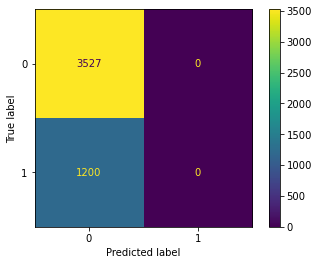

In [9]:
plot_confusion_matrix(dummy, X_test_scaled, y_test);

Baseline accuracy is 0.76

# I. Logistic Regression

In [10]:
LR = LogisticRegression(random_state=0)

LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3527
           1       0.59      0.32      0.42      1200

    accuracy                           0.77      4727
   macro avg       0.70      0.62      0.64      4727
weighted avg       0.75      0.77      0.75      4727



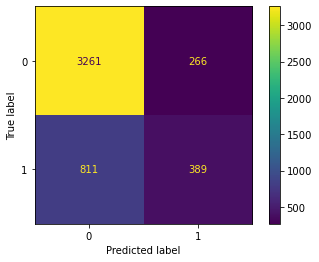

In [11]:
plot_confusion_matrix(LR, X_test_scaled, y_test);

This model does not perform much better than the baseline.

In [12]:
c_range = [0.001, 0.1, 1, 10, 100]
penalty = ['l2', 'l1']
solver = ['liblinear']

params_LR = {'C':c_range, 'penalty':penalty, 'solver':solver}

In [13]:
scoring= ['accuracy', 'roc_auc', 'neg_log_loss']

gridcv_LR = GridSearchCV(LR, param_grid=params_LR, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1)
gridcv_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 1, 10, 100], 'penalty': ['l2', 'l1'],
                         'solver': ['liblinear']},
             refit='accuracy', scoring=['accuracy', 'roc_auc', 'neg_log_loss'])

In [14]:
gridcv_LR.best_estimator_, gridcv_LR.best_params_, gridcv_LR.best_score_

(LogisticRegression(C=10, penalty='l1', random_state=0, solver='liblinear'),
 {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'},
 0.7761789480435093)

# II. Random Forest Classifier

In [15]:
RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3527
           1       0.56      0.37      0.45      1200

    accuracy                           0.77      4727
   macro avg       0.69      0.64      0.65      4727
weighted avg       0.75      0.77      0.75      4727



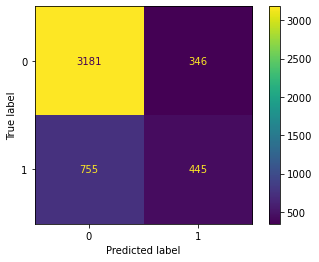

In [17]:
plot_confusion_matrix(RF, X_test_scaled, y_test);

# III. Gradient Boost Classifier

In [18]:
GB = GradientBoostingClassifier(random_state=0)

GB.fit(X_train_scaled, y_train)
y_pred = GB.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3527
           1       0.58      0.42      0.49      1200

    accuracy                           0.78      4727
   macro avg       0.70      0.66      0.67      4727
weighted avg       0.76      0.78      0.76      4727



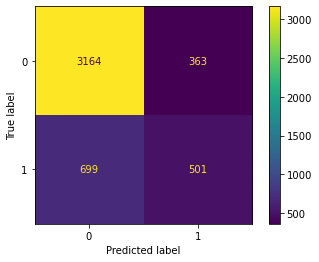

In [19]:
plot_confusion_matrix(GB, X_test_scaled, y_test);

# IV. XGBoost Model

In [29]:
XGB = xgb.XGBClassifier(objective='binary:logistic', random_state=0)

XGB.fit(X_train_scaled, y_train)
y_pred = XGB.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

C:\Users\divzu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:16:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.81      0.90      0.85      3527
           1       0.57      0.39      0.46      1200

    accuracy                           0.77      4727
   macro avg       0.69      0.64      0.66      4727
weighted avg       0.75      0.77      0.75      4727



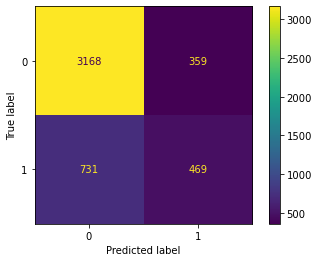

In [30]:
plot_confusion_matrix(XGB, X_test_scaled, y_test);